In [16]:
from Bio.Seq import Seq

#get aminoacid conversions from https://raw.githubusercontent.com/zhanxw/anno/master/codon.txt 
reverse_aa = {} 
dict_aa = {}
with open('codon.txt', 'r') as f: 
    for line in f: 
        if not line.startswith('#'):
            s = line.strip().split('\t')
           
            dict_aa[s[0]] = s[2] 
            
            if s[2] == 'O':
                continue
            if s[2] in reverse_aa.keys():
                t = reverse_aa[s[2]]
                t.append(s[0])
                reverse_aa[s[2]] = t
            else:
                reverse_aa[s[2]] = [s[0]]

        
            
#read in relative adaptive values from https://www.biologicscorp.com/tools/CAICalculator/ 
rel_weights = {} 
with open('yeast_rel_adapt_adj.txt', 'r') as f: 
    for line in f:  
        s = line.strip().split('\t')
        rel_weights[s[0]] = float(s[4])  
        
#define stop codons: 
stop_codons = []
for k in dict_aa.keys(): 
    if dict_aa[k] == 'O':
        stop_codons.append(k)

#read in elongation rates
elongate_dic = {}
with open('elongationrate.csv', 'r') as f: 
    for line in f:
        s = line.strip().split(';')
        elongate_dic[s[2]] = 1/(float(s[3]) / 10)
       
        
def get_codon_occurences(sequence): 
    codon_dict = {}

    
    #iterate through sequence in 3's to grab new codon
    i = 0
    while (i+3) < len(sequence):
        
        codon = sequence[i:i + 3]
       
        #increment frequency of codon appearances by one
      
        if codon not in codon_dict.keys():
            codon_dict[codon] = 1
        else:
            codon_dict[codon] += 1
        i += 3
        
    return codon_dict
    

def adj_for_stop(sequence): 
    i = 0
    while (i+3) < len(sequence):
        
        codon = sequence[i:i + 3]
       
        #increment frequency of codon appearances by one
        if codon in stop_codons: 
            return sequence[:i]
        
        i += 3 
    return sequence
    

#method to calc CAI
def calc_cai_cost(genomic_seq): 
    codon_freq = get_codon_occurences(genomic_seq)
    precai = 0 
    cost = 0 
    for k in codon_freq.keys():
        precai += codon_freq[k]*np.log(rel_weights[k])
        cost += codon_freq[k] * elongate_dic[k] 

    return np.exp(precai / (len(genomic_seq) /3)), cost

#method to combine potentials with a set buffer
def get_regions(pots):
    sort = sorted(pots)
    all_regions = []
    
    curset = []
    
    for i in range(1,len(sort)):
       
        cur = sort[i]
        prev = sort[i-1]
        curset.append(prev)
        if cur - prev <= buffer:
            
            curset.append(cur)
          
        else: 
            if len(curset) > 1: 
                all_regions.append([np.min(curset)- buffer, np.max(curset) + buffer])
                
            curset = []
    if len(curset) > 1: 
        all_regions.append([np.min(curset), np.max(curset)]) 
      
    
     
                
    return all_regions

fastaFile = 'yeast_gencode_all_exons_pcs_IDs_1L_filt.fa'
sequences = {} 
with open(fastaFile, 'r') as g: 
    for line in g: 
        l = line.strip()
        if l.startswith('>'):
            info = l.split(':')
            gene_name = info[-1]
        else: 
            raw_seq = l.upper()
            
            sequences[gene_name] = adj_for_stop(raw_seq)


id2prfloc = {}
with open('prfdb_S228C_all_nupack_unique_DNA_filtered_for_all.tsv','r') as f: 
    for line in f: 
        s = line.strip().split()
        info = int(s[1])
        if s[0] in id2prfloc.keys(): 
            temp = id2prfloc[s[0]]
            temp.append(info)
            id2prfloc[s[0]] = temp
        else: 
            id2prfloc[s[0]] = [info]

prf_ids = list(id2prfloc.keys())

inprf = {}
notinprf = {} 
for k in sequences.keys():
    if k in prf_ids:
        inprf[k] = sequences[k]  
    else: 
        notinprf[k] = sequences[k]
        


In [27]:
reverse_aa 

{'K': ['AAA', 'AAG'],
 'N': ['AAC', 'AAT'],
 'T': ['ACA', 'ACC', 'ACG', 'ACT'],
 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'],
 'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'],
 'I': ['ATA', 'ATC', 'ATT'],
 'M': ['ATG'],
 'Q': ['CAA', 'CAG'],
 'H': ['CAC', 'CAT'],
 'P': ['CCA', 'CCC', 'CCG', 'CCT'],
 'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'],
 'E': ['GAA', 'GAG'],
 'D': ['GAC', 'GAT'],
 'A': ['GCA', 'GCC', 'GCG', 'GCT'],
 'G': ['GGA', 'GGC', 'GGG', 'GGT'],
 'V': ['GTA', 'GTC', 'GTG', 'GTT'],
 'Y': ['TAC', 'TAT'],
 'C': ['TGC', 'TGT'],
 'W': ['TGG'],
 'F': ['TTC', 'TTT']}

In [37]:
fraction_vals = {}             
#read in geneome wide frequencies
freaks = {} 
with open('relative_freaks.tsv', 'r') as h: 
    for line in h: 
        s = line.strip().split('\t') 
        
        mrna = s[0].replace('U', 'T')
        freaks[mrna] = float(s[3]) 
        fraction_vals[mrna] = float(s[2])
       


{'TTT': 0.59,
 'TCT': 0.26,
 'TAT': 0.56,
 'TGT': 0.63,
 'TTC': 0.41,
 'TCC': 0.16,
 'TAC': 0.44,
 'TGC': 0.37,
 'TTA': 0.28,
 'TCA': 0.21,
 'TAA': 0.47,
 'TGA': 0.3,
 'TTG': 0.29,
 'TCG': 0.1,
 'TAG': 0.23,
 'TGG': 1.0,
 'CTT': 0.13,
 'CCT': 0.31,
 'CAT': 0.64,
 'CGT': 0.14,
 'CTC': 0.06,
 'CCC': 0.15,
 'CAC': 0.36,
 'CGC': 0.06,
 'CTA': 0.14,
 'CCA': 0.42,
 'CAA': 0.69,
 'CGA': 0.07,
 'CTG': 0.11,
 'CCG': 0.12,
 'CAG': 0.31,
 'CGG': 0.04,
 'ATT': 0.46,
 'ACT': 0.35,
 'AAT': 0.59,
 'AGT': 0.16,
 'ATC': 0.26,
 'ACC': 0.22,
 'AAC': 0.41,
 'AGC': 0.11,
 'ATA': 0.27,
 'ACA': 0.3,
 'AAA': 0.58,
 'AGA': 0.48,
 'ATG': 1.0,
 'ACG': 0.14,
 'AAG': 0.42,
 'AGG': 0.21,
 'GTT': 0.39,
 'GCT': 0.38,
 'GAT': 0.65,
 'GGT': 0.47,
 'GTC': 0.21,
 'GCC': 0.22,
 'GAC': 0.35,
 'GGC': 0.19,
 'GTA': 0.21,
 'GCA': 0.29,
 'GAA': 0.7,
 'GGA': 0.22,
 'GTG': 0.19,
 'GCG': 0.11,
 'GAG': 0.3,
 'GGG': 0.12}

In [50]:
afters = []
for k in id2prfloc.keys():
    if k not in sequences.keys():
        continue
    seq = sequences[k]
    locs = id2prfloc[k] 
  
    for l in locs:

        #afters.append(seq[l +6 : l + 36])
        afters.append(seq[l -91 : l + 95])

 
    
    
     
    

In [51]:

len(afters[1]) /3


62.0

In [42]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt 

In [52]:
seperated = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
print(len(seperated))
j = 0
for i in range(0,len(afters[1]),3):
    
    for a in afters: 
        temp = seperated[j] 
        temp.append(a[i:i + 3])
        seperated[j] = temp
    j += 1

counted = []
for t in seperated:
    counted.append(Counter(t))
len(counted)

62


62

In [53]:
len(reverse_aa.keys())

20

In [64]:
def smooth(data): # not like that time I walked into a bench infront of a pretty girl that was pretty unsmooth
    # will not smooth 2 codons in the prf site 
    smoothed = [] 
    for i in range(1,29): 
        smoothed.append(np.mean([data[i-1], data[i], data[i+1]]))
    
    for i in range(2):
        smoothed.append(np.nan)
    
    for i in range(33,len(data) -1): 
        smoothed.append(np.mean([data[i-1], data[i], data[i+1]]))

    return(smoothed)
    
        

        

# Graphs below
## Logarithmic now !!!!

/var/folders/7f/_vdp3w9j5r9_qyl5mkhz8pn00000gn/T/ipykernel_16969/4157771730.py:24: RuntimeWarning: divide by zero encountered in log
  new.append(np.log((float(vals[i]) / float(sums[i]))/ fraction_vals[key]))


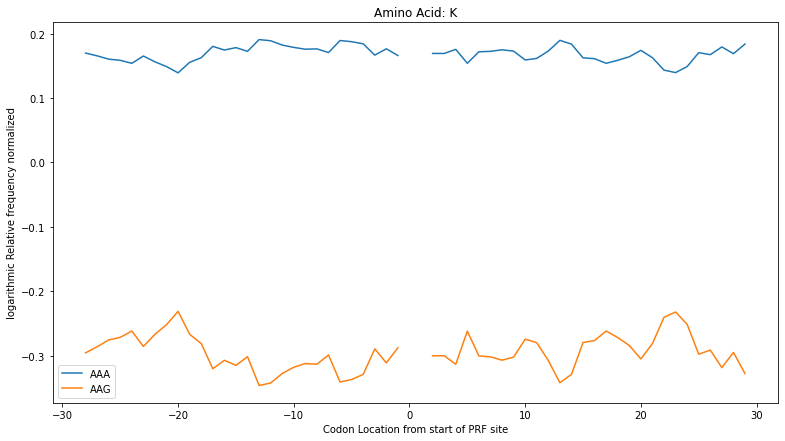

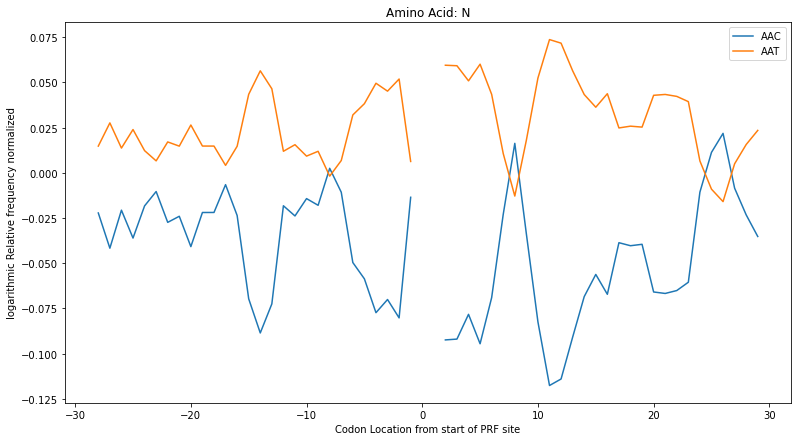

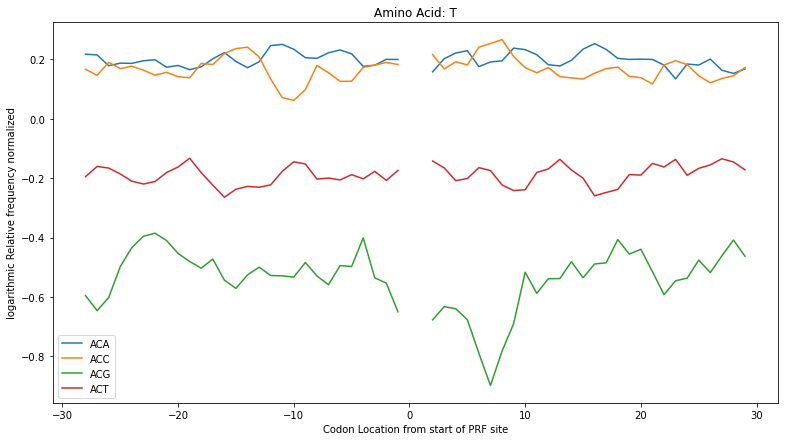

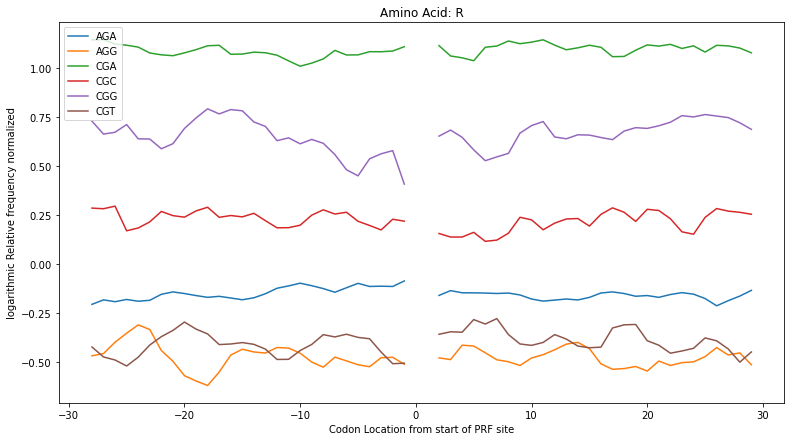

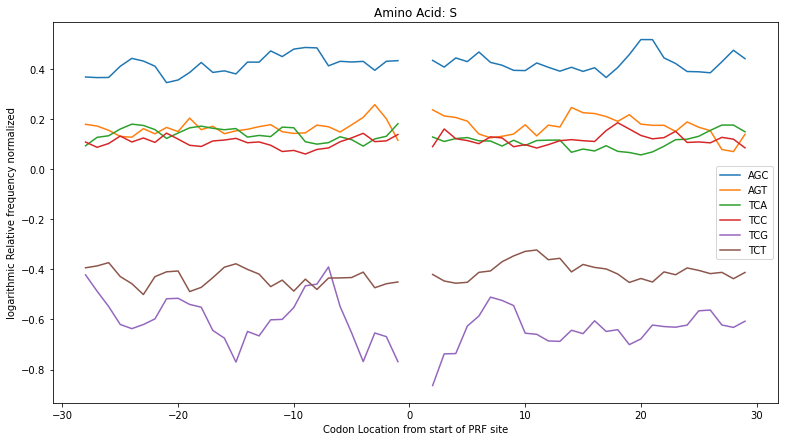

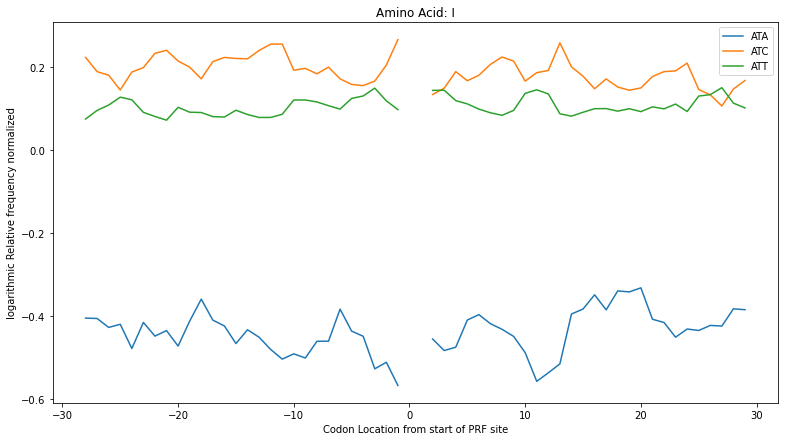

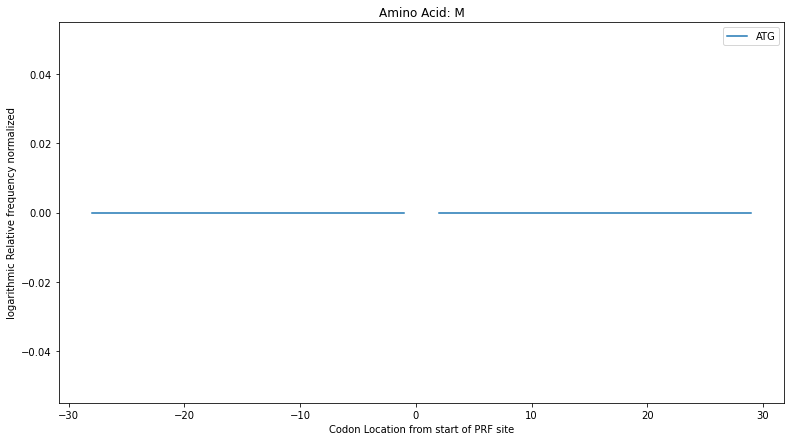

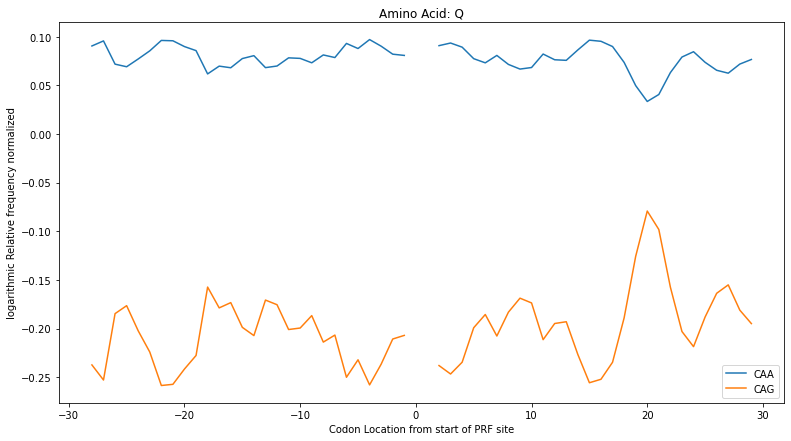

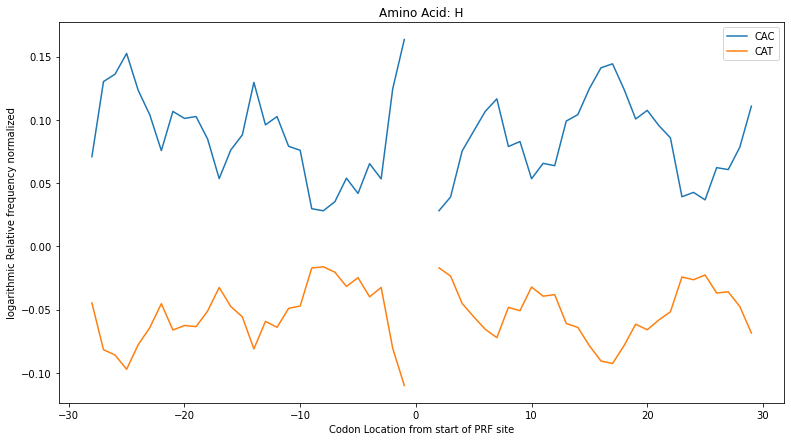

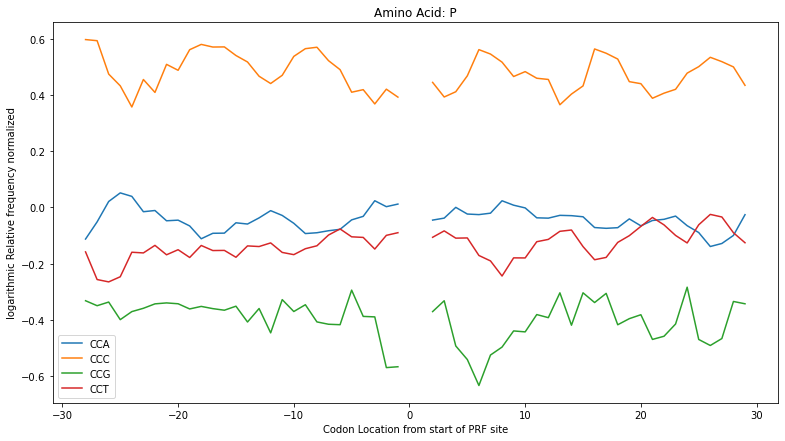

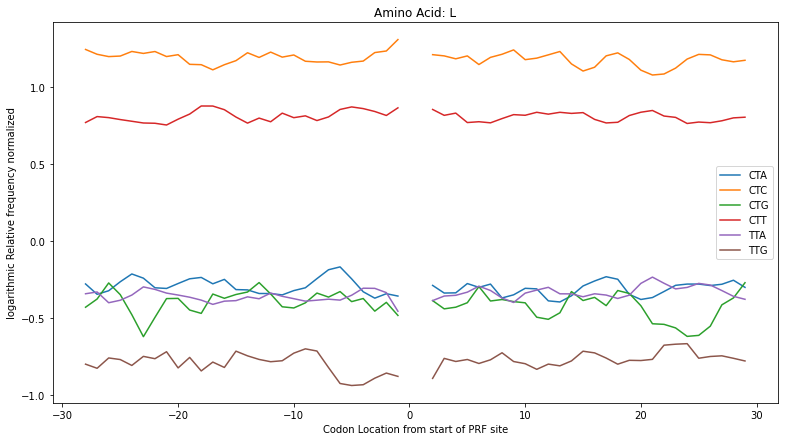

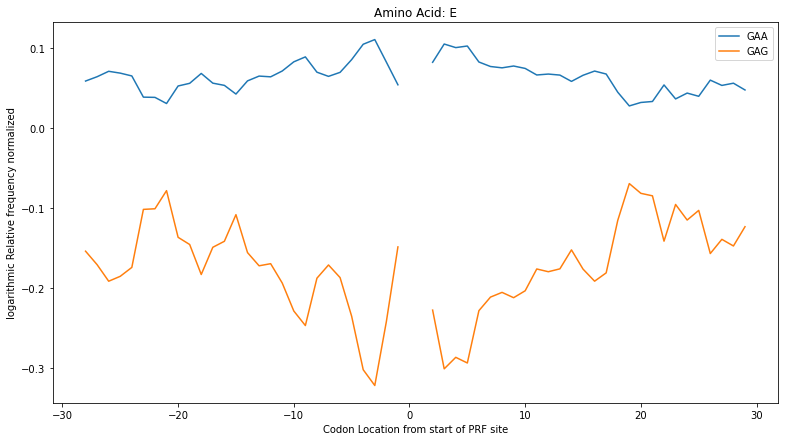

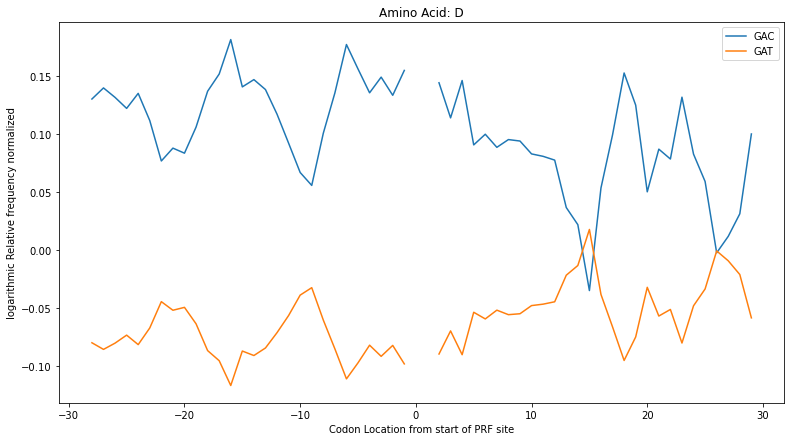

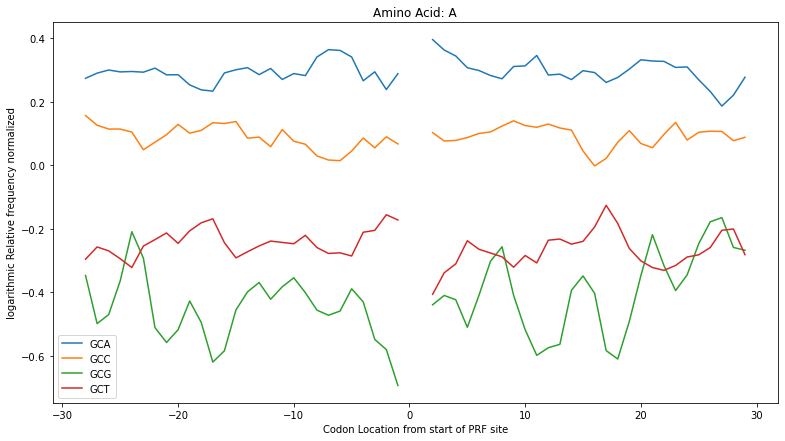

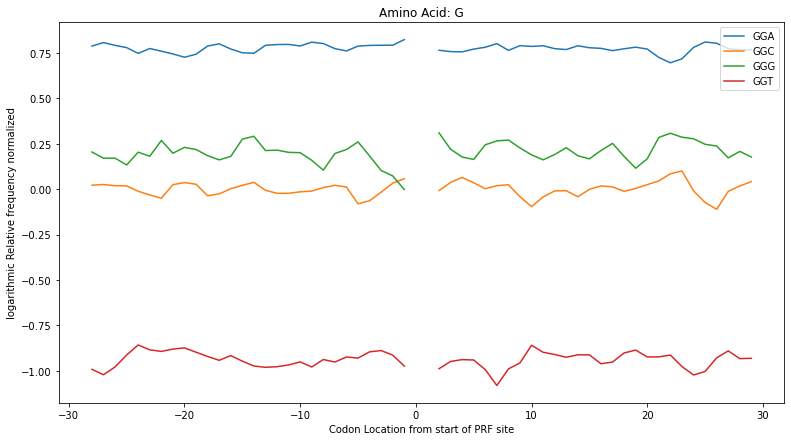

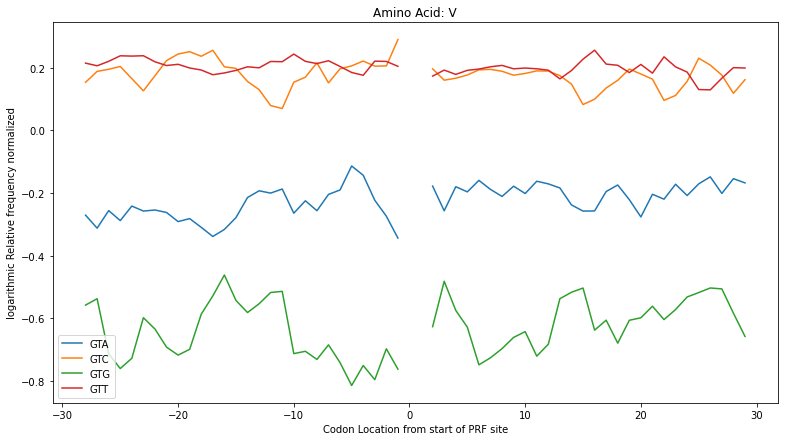

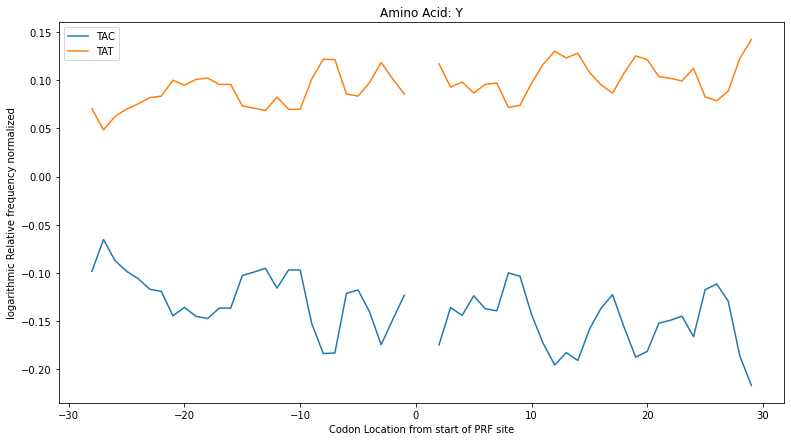

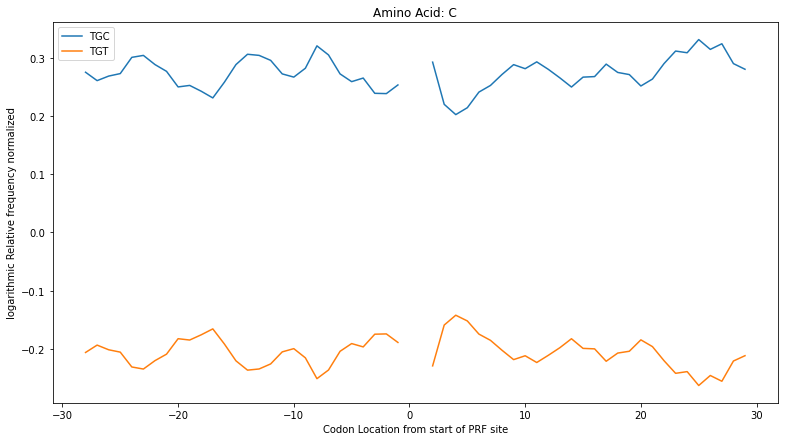

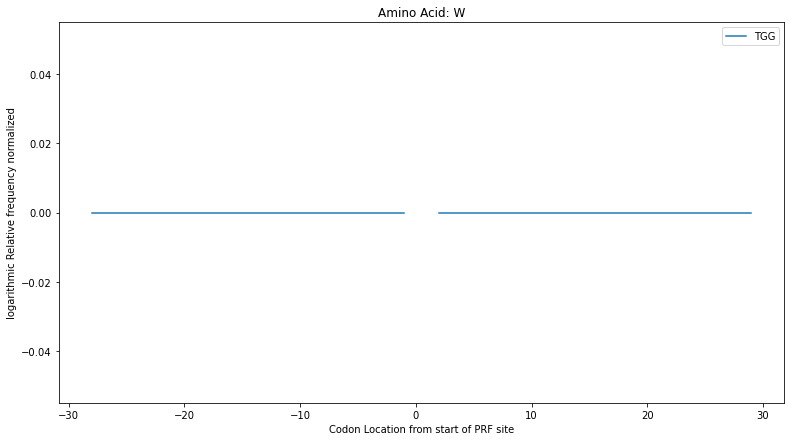

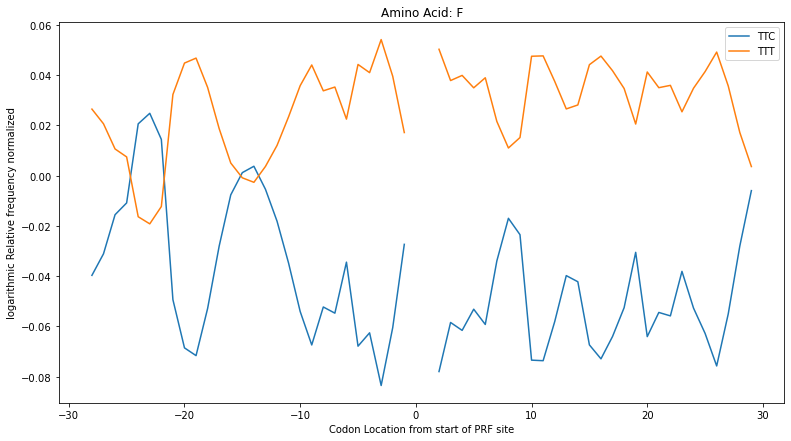

In [66]:
for k in reverse_aa.keys(): 
    
    codons = reverse_aa[k]
    rels = {}
    for c in codons:
        rels[c] = []
    for i in range(len(counted)): 
        cur = counted[i]
        for c in codons: 
            temp = rels[c]
            temp.append(cur[c])
            rels[c] = temp
    sums = np.zeros((len(seperated)))
    for key in rels.keys():
        vals = rels[key]
        for i in range(len(vals)): 
            sums[i] += vals[i]

    for key in rels.keys():
        vals = rels[key]
        new = []
        for i in range(len(vals)): 
            if sums[i] > 0: 
                new.append(np.log((float(vals[i]) / float(sums[i]))/ fraction_vals[key]))
            else:
                new.append(np.nan)
        rels[key] = new
        
        
    
          
    plt.figure(figsize = [13,7])
    for key in rels.keys(): 
       
        #plt.plot(range(-30, 32), rels[key])
        plt.plot(range(-28, 30), smooth(rels[key]))
    
        
    plt.title('Amino Acid: ' +  k)
    plt.legend(rels.keys())
    plt.ylabel('logarithmic Relative frequency normalized')
    plt.xlabel('Codon Location from start of PRF site')
  

   

# New
## compute frequency compared to all codons rather than relative 
to make sure I understood correctly this is what i did: 

Divided the occurences of a codon at a specific position by 15405 (this is how many snippets of 66 bp we took) , so this was the frequency of the occurences. 

Divided that frequency by the geneome wide frequency from that website to get a normalized score

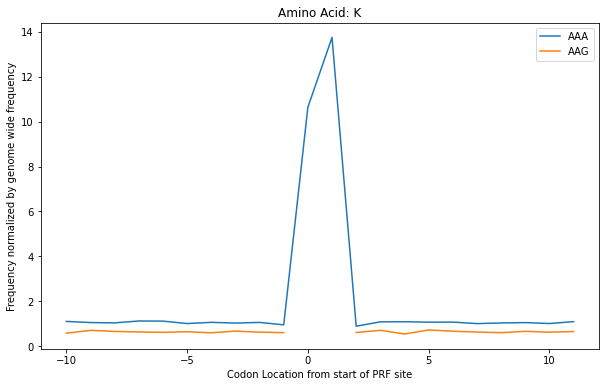

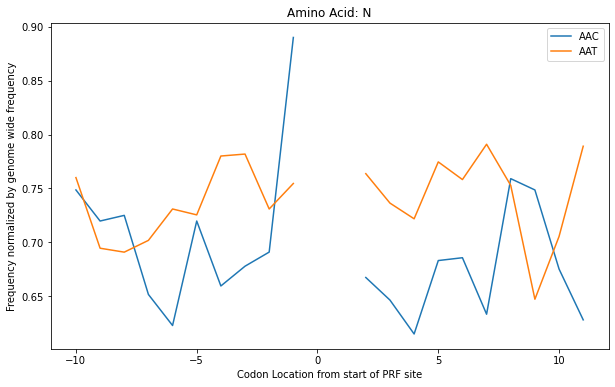

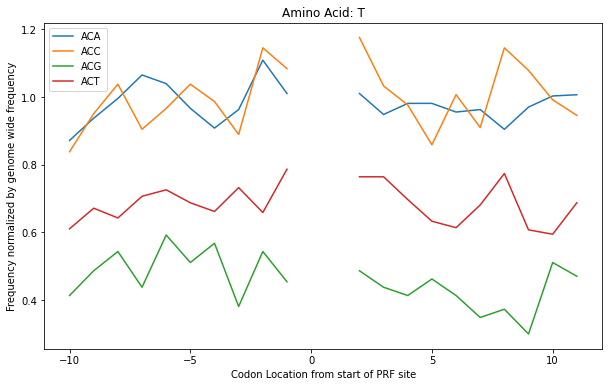

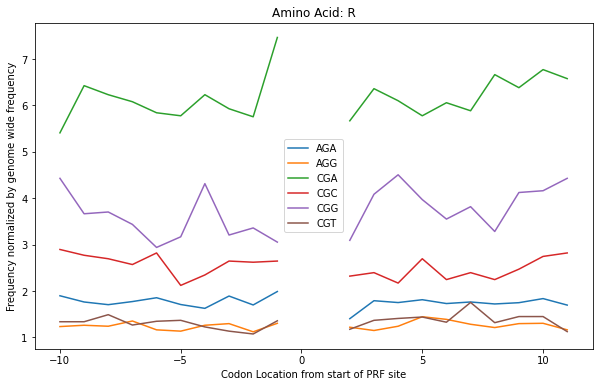

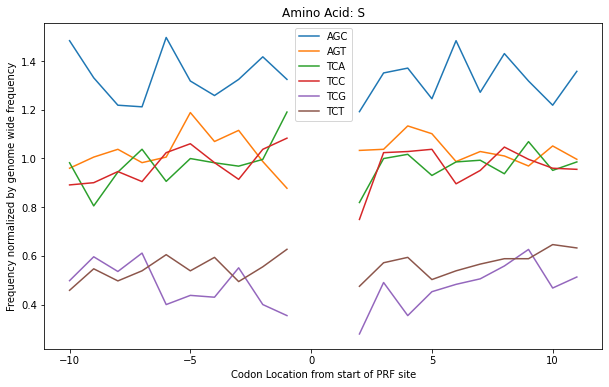

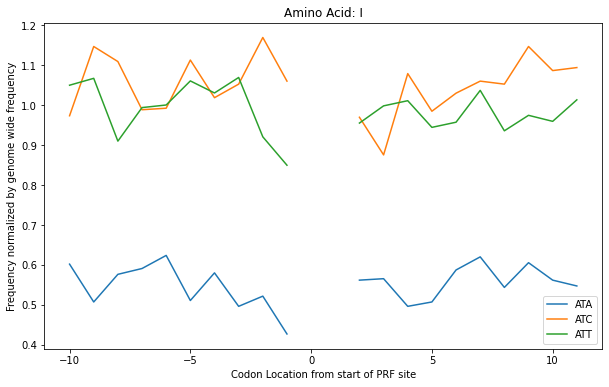

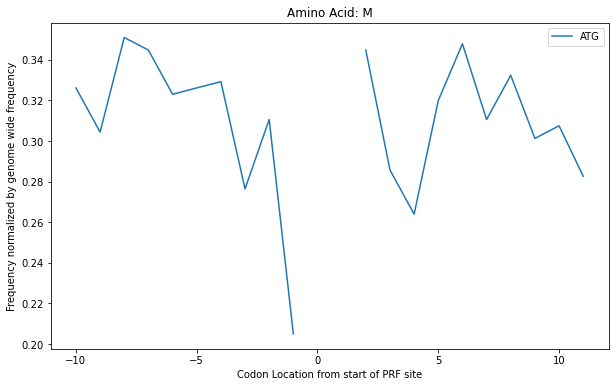

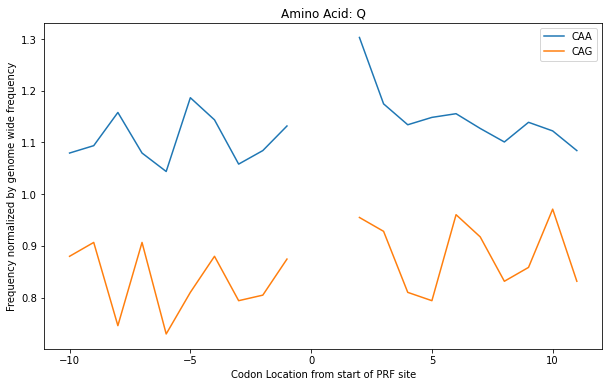

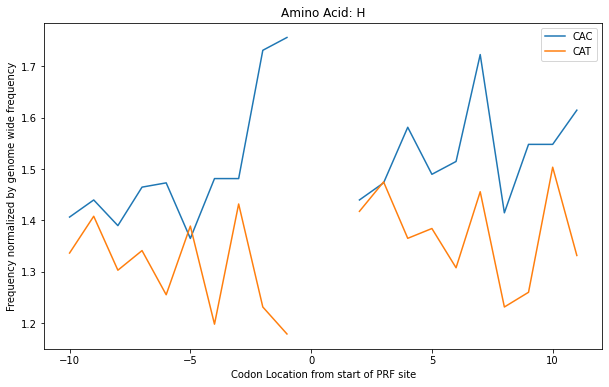

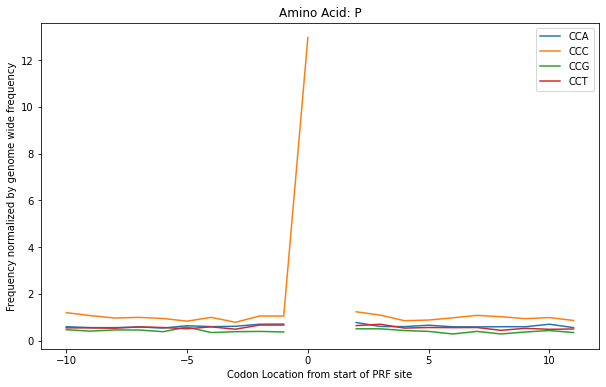

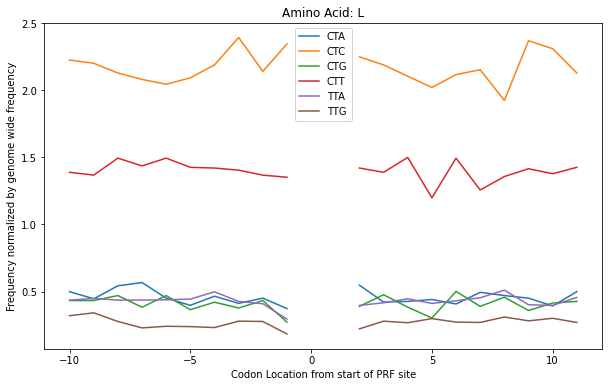

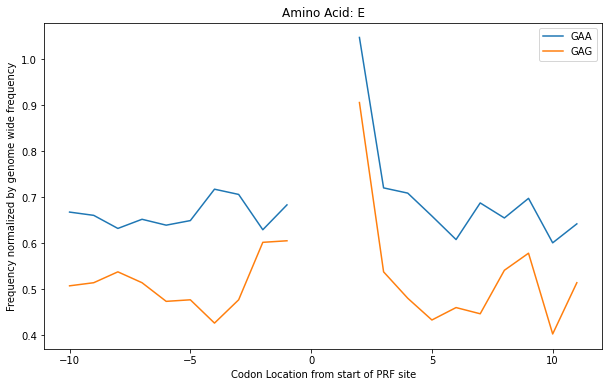

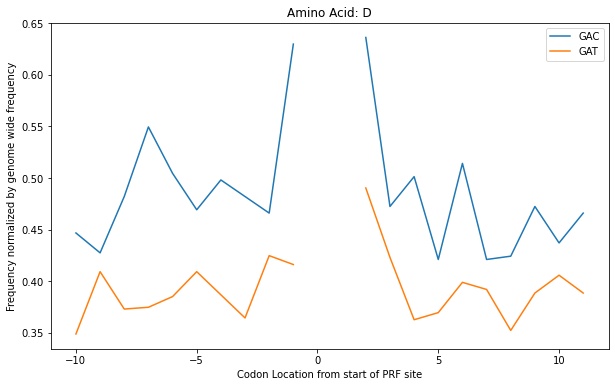

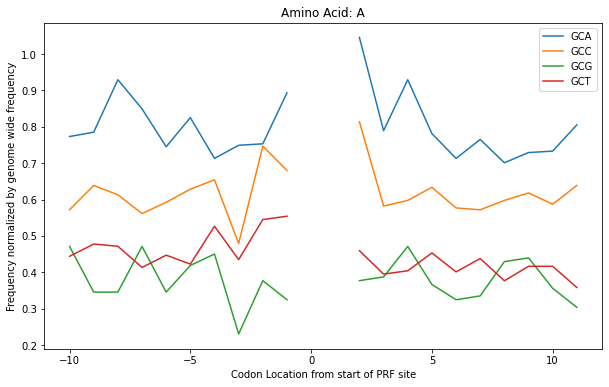

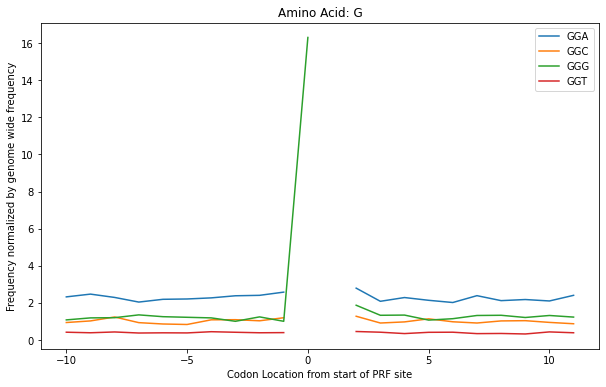

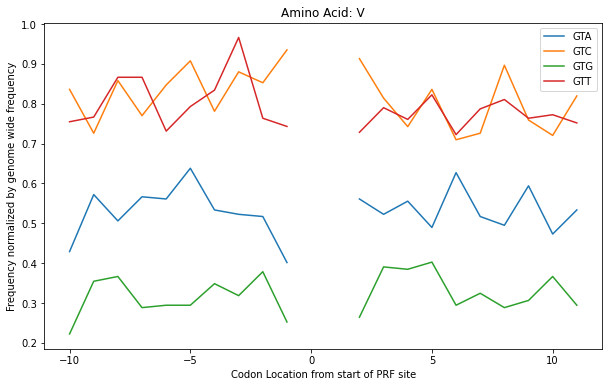

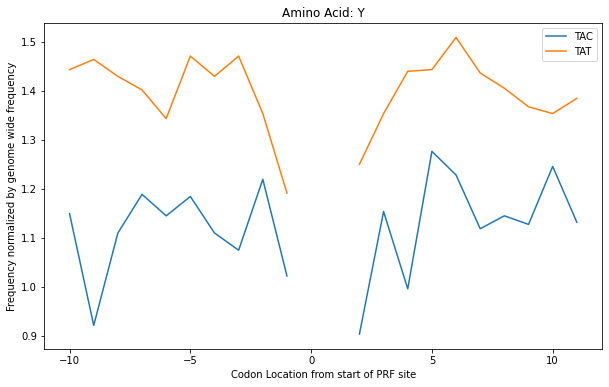

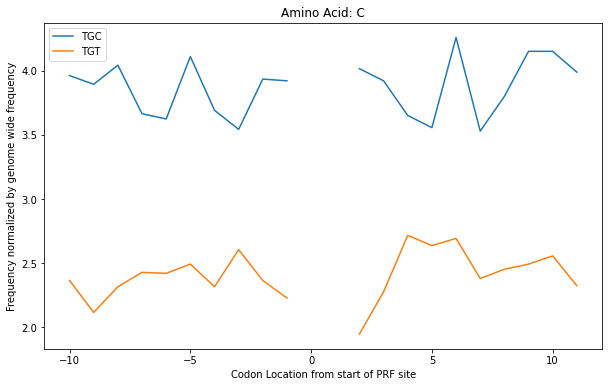

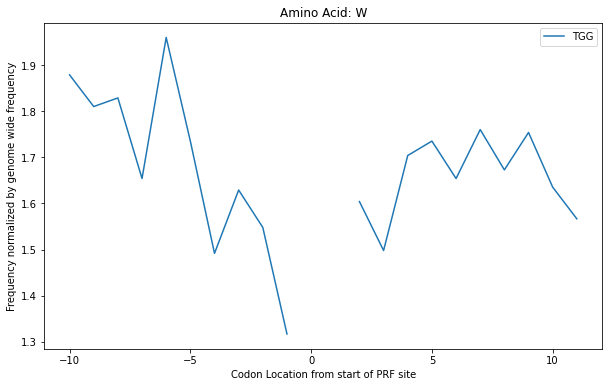

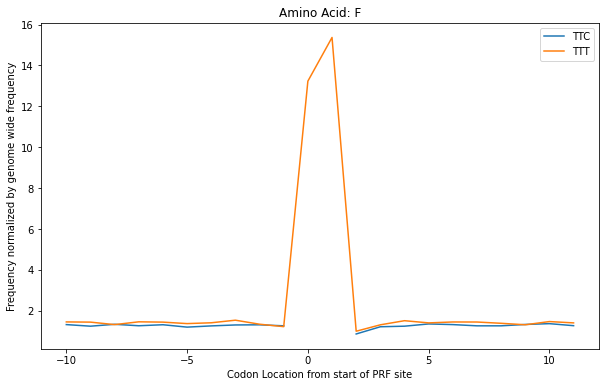

In [36]:
for k in reverse_aa.keys(): 
    
    codons = reverse_aa[k]
    rels = {}
    for c in codons:
        rels[c] = []
    for i in range(len(counted)): 
        cur = counted[i]
        for c in codons: 
            temp = rels[c]
            temp.append(cur[c])
            rels[c] = temp
     
   
    
    for key in rels.keys():
        vals = rels[key]
        new = []
        
        for i in range(len(vals)): 
            if vals[i] == 0: 
                new.append(np.nan)
            else:
                new.append((float(vals[i]) / 15.405) / freaks[key])
           
        rels[key] = new
    
    
    plt.figure(figsize = [10,6])
    for key in rels.keys(): 
        plt.plot(range(-10, 12), rels[key])
    plt.title('Amino Acid: ' +  k)
    plt.legend(rels.keys())
    plt.ylabel('Frequency normalized by genome wide frequency')
    plt.xlabel('Codon Location from start of PRF site')
    
  

15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
15405
